<a href="https://colab.research.google.com/github/VerbVal/ML_course_yandex/blob/main/01_reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW 4: Policy gradient
_Reference: based on Practical RL course by YSDA_

In this notebook you have to master Policy gradient Q-learning and apply it to familiar (and not so familiar) RL problems once again.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to the template file and submit it to the Contest.

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

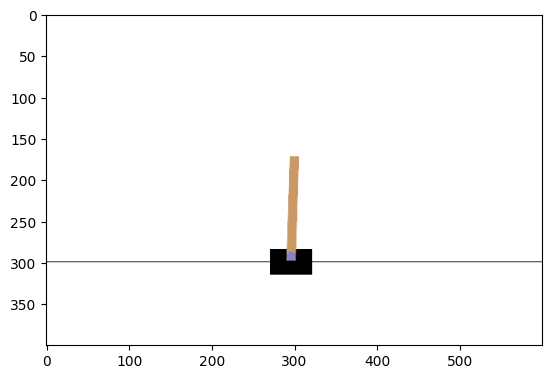

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

# Building the network for Policy Gradient (REINFORCE)

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Build a simple neural network that predicts policy logits.
# Keep it simple: CartPole isn't worth deep architectures.
class SimplePolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimplePolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

input_dim = state_dim[0]
output_dim = n_actions
model = SimplePolicyNetwork(input_dim, output_dim)
assert model is not None, "model is not defined"

In [ ]:
# do not change the code block below
batch_size_for_test = 5
example_states_batch = np.array([env.reset()[0] for _ in range(5)])
print(f"example_states_batch.shape: {example_states_batch.shape}")
assert example_states_batch.shape == (batch_size_for_test, state_dim[0])

example_logits = model(torch.from_numpy(example_states_batch))
print(f"example_logits.shape: {example_logits.shape}")
assert example_logits.shape == (batch_size_for_test, n_actions)
# do not change the code block above

example_states_batch.shape: (5, 4)
example_logits.shape: torch.Size([5, 2])


#### Predicting the action probas

Note: **output value of this function is not a torch tensor, it's a numpy array.**

So, here gradient calculation is not needed.

Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.

Also, `.detach()` can be used instead, but there is a difference:

* With `.detach()` computational graph is built but then disconnected from a particular tensor, so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
* In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [ ]:
def predict_probs(states, model):
    """
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :param model: torch model
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability

    # YOUR CODE GOES HERE
    with torch.no_grad():
      states_tensor = torch.tensor(states, dtype=torch.float32)
      logits = model(states_tensor)
      probs = F.softmax(logits, dim=-1)

    return probs.numpy()
    assert probs is not None, "probs is not defined"

    return probs

In [ ]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states, model)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [ ]:
def generate_session(env, t_max=1000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s, info = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]), model)[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, truncated, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [ ]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

To work with sequential environments we need the cumulative discounted reward for known for every state. To compute it we can **roll back** from the end of the session to the beginning and compute the discounted cumulative reward as following:

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [ ]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    # YOUR CODE GOES HERE
    cumulative_rewards = []
    G_next = 0
    for r in reversed(rewards):
        G_current = r + gamma * G_next
        cumulative_rewards.insert(0, G_current)
        G_next = G_current
    assert cumulative_rewards is not None, "cumulative_rewards is not defined"

    return cumulative_rewards

In [ ]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

Final loss should also include the entropy regularization term $H(\pi_\theta (a_i \mid s_i))$ to enforce the exploration:

$$
L = -\hat J(\theta) - \lambda H(\pi_\theta (a_i \mid s_i)),
$$
where $\lambda$ is the `entropy_coef`.

This function might be useful:

In [ ]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [ ]:
def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Compute the loss for the REINFORCE algorithm.
    """
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    probs = torch.softmax(logits, dim=-1)
    assert probs is not None, "probs is not defined"

    log_probs = torch.log(probs)
    assert log_probs is not None, "log_probs is not defined"

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    action_indices = actions.view(-1, 1)
    log_probs_for_actions = log_probs.gather(dim=1, index=action_indices).squeeze()
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"
    J_hat = -(cumulative_returns * log_probs_for_actions).mean()
    assert J_hat is not None, "J_hat is not defined"

    # Compute loss here. Don't forget entropy regularization with `entropy_coef`
    entropy = -(probs * log_probs).sum(dim=1).mean()
    assert entropy is not None, "entropy is not defined"
    loss = J_hat - entropy_coef * entropy
    assert loss is not None, "loss is not defined"

    return loss

In [ ]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    states = torch.tensor(states, dtype=torch.float32)
    logits = model(states)
    # cast everything into torch tensors
    loss = get_loss(logits, actions, rewards, n_actions=n_actions, gamma=gamma, entropy_coef=entropy_coef)
    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [ ]:
for i in range(500):
    rewards = [train_on_session(*generate_session(env), entropy_coef=1e-3) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 800:
        print("You Win!")  # but you can train even further
        break

mean reward:19.470
mean reward:20.850
mean reward:30.070
mean reward:31.060
mean reward:31.300
mean reward:29.930
mean reward:38.730
mean reward:50.120
mean reward:59.760
mean reward:85.590
mean reward:103.850
mean reward:131.530
mean reward:186.850
mean reward:230.640
mean reward:209.980
mean reward:247.230
mean reward:260.000
mean reward:162.310
mean reward:150.260
mean reward:168.280
mean reward:251.290
mean reward:330.150
mean reward:308.240
mean reward:210.160
mean reward:204.480
mean reward:420.380
mean reward:245.350
mean reward:342.070
mean reward:285.160
mean reward:227.580
mean reward:168.700
mean reward:155.780
mean reward:243.030
mean reward:345.420
mean reward:278.200
mean reward:199.290
mean reward:193.360
mean reward:258.740
mean reward:222.820
mean reward:478.380
mean reward:260.020
mean reward:163.150
mean reward:131.600
mean reward:149.820
mean reward:291.180
mean reward:307.720
mean reward:139.880
mean reward:127.410
mean reward:110.090
mean reward:117.600
mean rewar

### Watch the video of your results:

In [ ]:
import os
import numpy as np
import gymnasium as gym
from gymnasium.utils.save_video import save_video

env_for_video = gym.make("CartPole-v1", render_mode="rgb_array_list")
n_actions = env_for_video.action_space.n

episode_index = 0
step_starting_index = 0

obs, info = env_for_video.reset()

for step_index in range(800):
    probs = predict_probs(np.array([obs]), model)[0]
    action = np.random.choice(n_actions, p=probs)

    obs, reward, terminated, truncated, info = env_for_video.step(action)
    done = terminated or truncated

    if done or step_index == 799:
        # env_for_video.render() now returns the LIST of frames accumulated so far
        frames = env_for_video.render()
        os.makedirs("videos", exist_ok=True)
        save_video(
            frames, "videos",
            fps=env_for_video.metadata.get("render_fps", 30),
            step_starting_index=step_starting_index,
            episode_index=episode_index,
        )
        episode_index += 1
        step_starting_index = step_index + 1
        obs, info = env_for_video.reset()

env_for_video.close()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Congratulations! Finally, copy the `predict_probs`, `get_cumulative_rewards` and `get_loss` to the template and submit them to the Contest.

Good luck!

## Bonus part (no points, just for the interested ones)

Try solving the `Acrobot-v1` environment. It is more complex than regular `CartPole-v1`, so the default Policy Gradient (REINFORCE) algorithm might not work. Maybe the baseline idea could help...

![Acrobot](https://gymnasium.farama.org/_images/acrobot.gif)


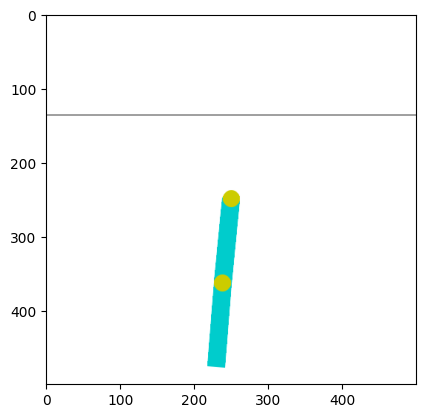

In [ ]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())

In [ ]:
# Your brave and victorious code here.
import torch.optim as optim
from torch.distributions import Categorical
class PolicyNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

policy_net = PolicyNet(state_dim, n_actions)
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

def select_action(state):
    probs = policy_net(torch.tensor(state).float().unsqueeze(0)).squeeze(0)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.item(), log_prob

def compute_returns(rewards, gamma):
    returns = []
    running_return = 0
    for r in reversed(rewards):
        running_return = r + gamma * running_return
        returns.insert(0, running_return)
    return torch.tensor(returns)

def reinforce(episodes=1000, gamma=0.99):
    rewards_history = []
    loss_history = []
    best_reward = float('-inf')

    for episode in range(episodes):
        done = False
        total_reward = 0
        log_probs = []
        rewards = []
        state, _ = env.reset()

        while not done:
            action, log_prob = select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            total_reward += reward
            state = next_state

        returns = compute_returns(rewards, gamma)
        baseline = torch.mean(returns)
        advantages = returns - baseline

        loss = (-torch.stack(log_probs) * advantages.detach()).sum() / len(log_probs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rewards_history.append(total_reward)
        loss_history.append(loss.item())

        if total_reward > best_reward:
            best_reward = total_reward

        print(f'Episode {episode+1}, Total Reward: {total_reward:.2f}')

reinforce()

Episode 1, Total Reward: -329.00
Episode 2, Total Reward: -388.00
Episode 3, Total Reward: -426.00
Episode 4, Total Reward: -424.00
Episode 5, Total Reward: -427.00
Episode 6, Total Reward: -488.00
Episode 7, Total Reward: -471.00
Episode 8, Total Reward: -305.00
Episode 9, Total Reward: -493.00
Episode 10, Total Reward: -168.00
Episode 11, Total Reward: -227.00
Episode 12, Total Reward: -281.00
Episode 13, Total Reward: -321.00
Episode 14, Total Reward: -192.00
Episode 15, Total Reward: -377.00
Episode 16, Total Reward: -210.00
Episode 17, Total Reward: -262.00
Episode 18, Total Reward: -188.00
Episode 19, Total Reward: -257.00
Episode 20, Total Reward: -280.00
Episode 21, Total Reward: -206.00
Episode 22, Total Reward: -280.00
Episode 23, Total Reward: -195.00
Episode 24, Total Reward: -231.00
Episode 25, Total Reward: -271.00
Episode 26, Total Reward: -159.00
Episode 27, Total Reward: -292.00
Episode 28, Total Reward: -205.00
Episode 29, Total Reward: -184.00
Episode 30, Total Rewar

Test Episode 1: Total Reward=-72.00
Test Episode 2: Total Reward=-127.00
Test Episode 3: Total Reward=-100.00
Test Episode 4: Total Reward=-74.00
Test Episode 5: Total Reward=-98.00
Test Episode 6: Total Reward=-72.00
Test Episode 7: Total Reward=-89.00
Test Episode 8: Total Reward=-101.00
Test Episode 9: Total Reward=-90.00
Test Episode 10: Total Reward=-73.00
Test Episode 11: Total Reward=-210.00
Test Episode 12: Total Reward=-100.00
Test Episode 13: Total Reward=-119.00
Test Episode 14: Total Reward=-91.00
Test Episode 15: Total Reward=-94.00
Test Episode 16: Total Reward=-91.00
Test Episode 17: Total Reward=-98.00
Test Episode 18: Total Reward=-82.00
Test Episode 19: Total Reward=-78.00
Test Episode 20: Total Reward=-65.00
Test Episode 21: Total Reward=-117.00
Test Episode 22: Total Reward=-74.00
Test Episode 23: Total Reward=-73.00
Test Episode 24: Total Reward=-78.00
Test Episode 25: Total Reward=-121.00
Test Episode 26: Total Reward=-104.00
Test Episode 27: Total Reward=-92.00
T

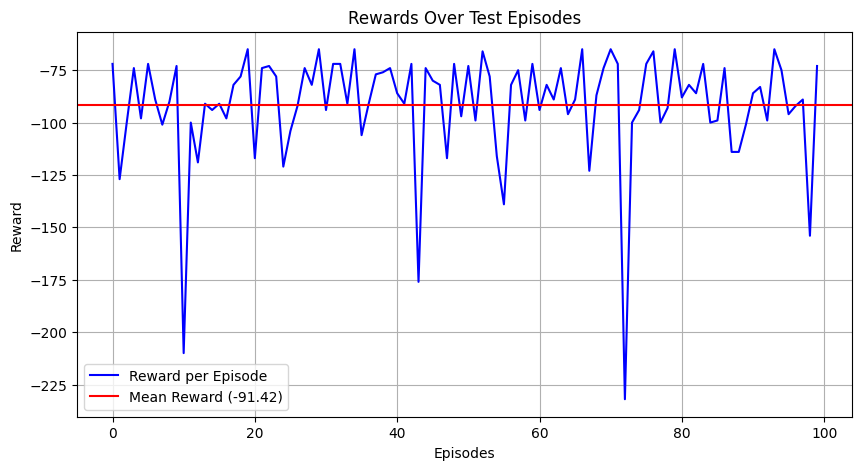

In [ ]:
num_episodes = 100
gamma = 0.99

reward_history = []

for i in range(num_episodes):
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        probs = policy_net(torch.tensor(state).float().unsqueeze(0)).squeeze(0)
        action = torch.argmax(probs).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    reward_history.append(total_reward)
    print(f'Test Episode {i+1}: Total Reward={total_reward:.2f}')

avg_reward = sum(reward_history) / num_episodes
print(f'\\nAverage Reward over {num_episodes} episodes: {avg_reward:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(range(len(reward_history)), reward_history, label='Reward per Episode', color='b')
plt.axhline(y=np.mean(reward_history), color='r', linestyle='-', label=f'Mean Reward ({avg_reward:.2f})')
plt.title('Rewards Over Test Episodes')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()